<a href="https://colab.research.google.com/github/tony0990/Plant-Diseases-Full-Project/blob/main/AI_Project_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/plantvillage_dataset/saved_models

In [ ]:
!ls "/content/drive/MyDrive/plantvillage_dataset"


color  grayscale  segmented


In [ ]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES


In [ ]:
import os
dataset_path ="/content/drive/MyDrive/plantvillage_dataset/color"

selected_classes = [
    cls for cls in allowed_classes
    if os.path.isdir(os.path.join(dataset_path, cls))
]

print("Selected Classes:")
for cls in selected_classes:
    print(cls)

print("Number of classes:", len(selected_classes))


Selected Classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

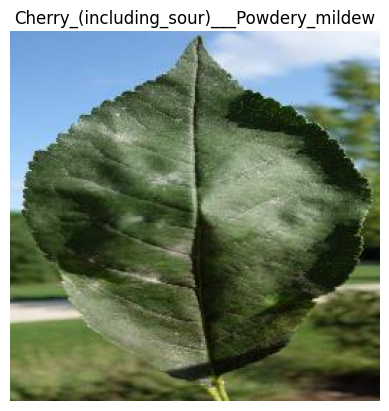

In [ ]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")


In [ ]:
import tensorflow as tf
EfficientNetB3 = tf.keras.applications.EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

#resize
IMG_SIZE = 256
BATCH_SIZE = 16
SEED = 42

#normzlization
def normalize_efficientnet(x, y):
    x = tf.cast(x, tf.float32)
    x = (x / 127.5) - 1.0
    return x, y


full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=True,
    seed=SEED
)

full_ds = full_ds.map(normalize_efficientnet,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [ ]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: -1.0
Max: 1.0
Shape: (16, 256, 256, 3)


In [ ]:
#(70% train, 15% val, 15% test)
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)

val_ds  = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


In [ ]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 365
Train batches           : 255
Validation batches      : 54
Test batches            : 56


In [ ]:
def count_images(ds):
    return sum(1 for _ in ds.unbatch())

print("Total images :", count_images(full_ds))
print("Train images :", count_images(train_ds))
print("Val images   :", count_images(val_ds))
print("Test images  :", count_images(test_ds))


Total images : 5825
Train images : 4080
Val images   : 864
Test images  : 881


In [ ]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
def get_class_counts(ds, name):
    labels = []
    for _, y in ds.unbatch():
        labels.append(int(tf.argmax(y)))
    from collections import Counter
    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {2: 809, 3: 843, 4: 727, 1: 708, 0: 993}
VAL class counts: {4: 143, 0: 211, 3: 186, 2: 177, 1: 147}
TEST class counts: {1: 148, 3: 173, 4: 175, 0: 188, 2: 197}


In [ ]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

labels = np.array(labels)


In [ ]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)


Class counts: {4: 731, 3: 836, 0: 989, 2: 812, 1: 712}


In [ ]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")


Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 731 samples
3 (Corn_(maize)___Common_rust_) → 836 samples
0 (Tomato___Target_Spot) → 989 samples
2 (Grape___Black_rot) → 812 samples
1 (Pepper,_bell___Bacterial_spot) → 712 samples


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8250758341759353, 1: 1.146067415730337, 2: 1.0049261083743843, 3: 0.9760765550239234, 4: 1.1162790697674418}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Number of classes
NUM_CLASSES = num_classes

# Load DenseNet121 base model
base_model_densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model
base_model_densenet.trainable = False

# Custom classification head
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.6)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

# Final model
densenet_model = Model(
    inputs=base_model_densenet.input,
    outputs=output
)

densenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 262, 262,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,349 (27.35 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
!mkdir -p /content/drive/MyDrive/plantvillage_dataset/saved_models

mkdir: cannot create directory ‘/content/drive/MyDrive/plantvillage_dataset/saved_models’: Read-only file system


In [ ]:
import os
import tensorflow as tf

model_save_dir = "/content/drive/MyDrive/plantvillage_dataset/saved_models"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_save_dir, "densenet_best_model.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb]


In [ ]:
EPOCHS = 20 # Define the number of epochs
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_densenet = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4910 - loss: 1.4670
Epoch 1: val_loss improved from inf to 0.26078, saving model to /content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 178ms/step - accuracy: 0.4917 - loss: 1.4650 - val_accuracy: 0.9769 - val_loss: 0.2608
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9125 - loss: 0.3504
Epoch 2: val_loss improved from 0.26078 to 0.11872, saving model to /content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.9126 - loss: 0.3502 - val_accuracy: 0.9861 - val_loss: 0.1187
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9613 - loss: 0.1930
Epoch 3: val_loss improved from 0.11872 to 0.06986, saving model to /content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accu

In [ ]:
!ls /content/drive/MyDrive/plantvillage_dataset/saved_models

densenet_best_model.keras


In [ ]:
best_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras"
)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 223ms/step - accuracy: 0.9995 - loss: 0.0147
Test Accuracy: 0.9989


In [ ]:
import numpy as np

y_pred = best_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step


In [ ]:
y_true = np.argmax(y_true, axis=1)

In [ ]:
!ls /content/drive/MyDrive/plantvillage_dataset

color  grayscale  saved_models	segmented


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/plantvillage_dataset/color"

class_names = sorted([
    d for d in os.listdir(BASE_DIR)
    if os.path.isdir(os.path.join(BASE_DIR, d))
])

print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
print("Unique labels in y_true:", np.unique(y_true))
print("Number of classes predicted:", len(np.unique(y_true)))

Unique labels in y_true: [0 1 2 3 4]
Number of classes predicted: 5


In [ ]:
class_names = [
    "Apple___Black_rot",
    "Apple___healthy",
    "Corn___Gray_leaf_spot",
    "Potato___Late_blight",
    "Tomato___healthy"
]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))


                       precision    recall  f1-score   support

    Apple___Black_rot       0.19      0.19      0.19       193
      Apple___healthy       0.07      0.06      0.07       139
Corn___Gray_leaf_spot       0.23      0.24      0.23       195
 Potato___Late_blight       0.17      0.17      0.17       173
     Tomato___healthy       0.21      0.20      0.21       181

             accuracy                           0.18       881
            macro avg       0.17      0.17      0.17       881
         weighted avg       0.18      0.18      0.18       881



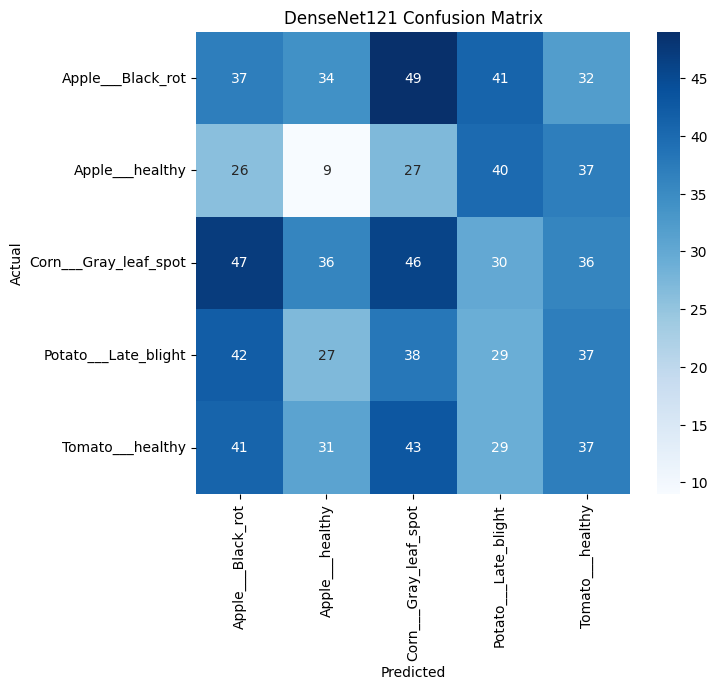

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DenseNet121 Confusion Matrix")
plt.show()

In [ ]:
for layer in base_model_densenet.layers[-30:]:
    layer.trainable = True

In [ ]:
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history_finetune = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9465 - loss: 0.1680
Epoch 1: val_loss did not improve from 0.01416
255/255 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.9466 - loss: 0.1678 - val_accuracy: 0.9988 - val_loss: 0.0159
Epoch 2/5
254/255 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9862 - loss: 0.0600
Epoch 2: val_loss improved from 0.01416 to 0.01328, saving model to /content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.9862 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9893 - loss: 0.0501
Epoch 3: val_loss improved from 0.01328 to 0.01315, saving model to /content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.9893 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━

In [ ]:
best_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/plantvillage_dataset/saved_models/densenet_best_model.keras"
)

In [ ]:
train_loss, train_acc = best_model.evaluate(train_ds, verbose=0)
val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy:   {val_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

Train Accuracy: 1.0000
Val Accuracy:   1.0000
Test Accuracy:  0.9989


In [ ]:
import numpy as np

y_pred = best_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))


                       precision    recall  f1-score   support

    Apple___Black_rot       0.27      0.27      0.27       193
      Apple___healthy       0.13      0.14      0.13       139
Corn___Gray_leaf_spot       0.25      0.25      0.25       195
 Potato___Late_blight       0.23      0.22      0.22       173
     Tomato___healthy       0.18      0.17      0.17       181

             accuracy                           0.22       881
            macro avg       0.21      0.21      0.21       881
         weighted avg       0.22      0.22      0.22       881



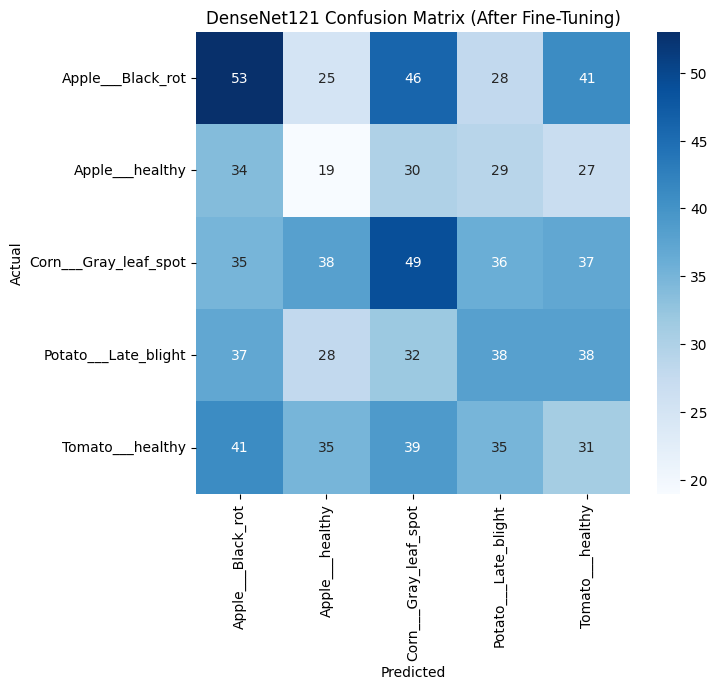

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DenseNet121 Confusion Matrix (After Fine-Tuning)")
plt.show()


In [ ]:
print("Before fine-tuning accuracy  ≈ 0.18")
print(f"After fine-tuning accuracy   = {test_acc:.4f}")

Before fine-tuning accuracy  ≈ 0.18
After fine-tuning accuracy   = 0.9989


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)